In [4]:
#CAPSTONE PROJECT
#CARSON WARD , JORGE SEMPERE


#All libraries plus modules necessary
# Pull info off of Pro Football Reference
from urllib.request import urlopen
from bs4 import BeautifulSoup
# data storing plus manipulating
import pandas as pd
import numpy as np
# graphing
import matplotlib as mpl
import matplotlib.pyplot as plt

# given the input of a year, scrapes statistics for passing from Pro Football Reference
def compilestats(year):

    #All passing pages follow same format, minus year
    html = urlopen('https://www.pro-football-reference.com/years/' + str(year) +'/passing.htm')
    statspage = BeautifulSoup(html)
    column_headers = statspage.findAll('tr')[0]
    column_headers = [i.getText() for i in column_headers.findAll('th')]
    
    # Collect table rows
    rows = statspage.findAll('tr')[1:]
    
    # Get stats from each row
    stats = []
    for i in range(len(rows)):
        stats.append([col.getText() for col in rows[i].findAll('td')])
     
    # Create DataFrame from our scraped data
    data = pd.DataFrame(stats, columns=column_headers[1:])

    #Rename categories for readability of the layman
    newcols = data.columns.values
    newcols[9] = 'Completion %'
    newcols[11] = 'Touchdowns'
    newcols[13] = 'Interceptions'
    newcols[10] = 'Yards'
    newcols[17] = 'Yards/Attempt'
    data.columns = newcols
    data.columns

    # Select stat categories to be used in program
    categories = ['GS','Completion %', 'Yards', 'Touchdowns', 'Interceptions', 'Yards/Attempt']

    # Create data subset for league average chart
    data_avg = data[['Player', 'Tm'] + categories]

    # Convert data to numerical values
    pd.options.mode.chained_assignment = None  # default='warn'
    for i in categories:
        data_avg[i] = pd.to_numeric(data[i])
        

    # Filter by passing yards to eliminate players that should not qualify when calculating league averages
    # Ensures all data will be useful and will not drag down league averages
    data_avg_filtered = data_avg[data_avg['GS'] > 7]
    data_avg_filtered = data_avg_filtered[data_avg_filtered['Yards'] > 400]
    data = data_avg_filtered
    return data

#NEXT TWO FUNCTIONS ARE HELPER FUNCTIONS FOR COMPILING LEAGUE STATISTICS
#quick function to scrape data from page and convert to averages for given year
def compilestatsAvg(data):
    average = (data['Completion %'].mean(),data['Touchdowns'].mean(),data['Interceptions'].mean(),data['Yards'].mean(),data['Yards/Attempt'].mean())
    return average

#quick function to scrape data from page and convert to standard deviations for given year
def compilestatsSD(data):
    average = (data['Completion %'].std(),data['Touchdowns'].std(),data['Interceptions'].std(),data['Yards'].std(),data['Yards/Attempt'].std())
    return average

#returns tuple of league average statistics for a 5 year sample
#input is starting year for the sample
def leagueAvg(startyear):
    total = (0,0,0,0,0)
    for i in range(0,5):
        average = compilestatsAvg(compilestats(int(startyear)+i))
        total = tuple([sum(x) for x in zip(total,average)])
    avg = tuple(a/5 for a in total)
    avg = tuple(round(a,2) for a in avg)
    return avg

#returns tuple of standard deviations of league average statistics for a 5 year sample
#input is starting year for the sample
def leagueSD(startyear):
    total = (0,0,0,0,0)
    for i in range(0,5):
        average = compilestatsSD(compilestats(int(startyear)+i))
        total = tuple([sum(x) for x in zip(total,average)])
    avg = tuple(a/5 for a in total)
    avg = tuple(round(a,3) for a in avg)
    return avg


la = leagueAvg(2016)
#print(la)
lsd = leagueSD(2016)
#print(lsd)

In [5]:
#Function to determine what is added to longevity based on comparison to league average
#Checks within how many standard deviations stats are and assigns a score based upon that number
#If stats are above the league average, score will be lower (leading to longer career)
#If stats are below league average, score will be higher (shorter career)
def longevity(stats,leagueaverage,lsd):
    sd = tuple(map(lambda i, j: i - j, stats,leagueaverage ))
    # makes the standard deviation for interceptions negative, as a positive standard deviation for a negative stat
    # was making the career of a player who threw a lot of interceptions longer than it should've been
    lsd = list(lsd)
    lsd[2] = -lsd[2]
    lsd = tuple(lsd)
    sd = tuple(ele1 / ele2 for ele1, ele2 in zip(sd,lsd ))
    long = sum(sd)/5
    if long <= 0.4 and long > -0.4:
        long = 0.08
    elif long <= -0.4 and long > -1.2:
        long = 0.13
    elif long > 0.4 and long < 1.2:
        long = 0.06
    elif long <= -1.2:
        long = 0.17
    else:
        long = 0.04
    return long
    


In [6]:
import random

#Predicts the next years stats for the player given the previous years stats by randomly generating multipliers for each stat
#These multipliers are around 1 to ensure the stats are believable based upon the previous year
def predictStats(stats):
    multipliers = (random.uniform(0.95,1.05),random.uniform(0.8,1.2),random.uniform(0.8,1.2),random.uniform(0.9,1.1),random.uniform(0.9,1.1))
    newstats = tuple(ele1 * ele2 for ele1, ele2 in zip(stats,multipliers))
    newstats = tuple(round(a,2) for a in newstats)
    templist = list(newstats)
    templist[1] = round(templist[1],0)
    templist[2] = round(templist[2],0)
    templist[3] = round(templist[3],0)
    newstats = tuple(templist)
    return newstats



In [7]:
class Quarterback:
    def __init__(self, age):
        self.age = age
        self.longevity = 0
        self.ageMultiplier = 1
        self.seasonStats = (0,)
        
    def obtainStats(self):
        for i in range(1,3):
            print("SEASON " + str(i) + " (Age: " + str(self.age + i - 1) + ")")  
            compPer = float(input("Completion %: "))
            TD = float(input("TD: "))
            interceptions = float(input("Interceptions: "))
            yards = float(input("Yards: "))
            yardsPerAttempt = float(input("Yards/Attempt: "))
            print("\n")
            if i == 1:
                self.seasonOneStats = (compPer, TD, interceptions, yards, yardsPerAttempt)
            elif i == 2:
                self.seasonTwoStats = (compPer, TD, interceptions, yards, yardsPerAttempt)
        self.avgStats = tuple([sum(x) for x in zip(self.seasonOneStats, self.seasonTwoStats)])
        self.avgStats = tuple(a/2 for a in self.avgStats)
        self.avgStats = tuple(round(a,3) for a in self.avgStats)

        
qb = Quarterback(23)
qb.obtainStats()

SEASON 1 (Age: 23)


Completion %:  66.6
TD:  31
Interceptions:  10
Yards:  4336
Yards/Attempt:  7.4




SEASON 2 (Age: 24)


Completion %:  66.6
TD:  31
Interceptions:  10
Yards:  4336
Yards/Attempt:  7.4


In [8]:
careerStats = (0,0,0,0,0)
#calculate longevity rating based on the qb's first two seasons worth of stats
qb.longevity = 0
startAge = qb.age
qb.longevity += longevity(qb.seasonOneStats,la,lsd)
qb.age += 1
qb.ageMultiplier += 0.1

qb.longevity += longevity(qb.seasonTwoStats,la,lsd)
qb.age += 1
qb.ageMultiplier += 0.1


#Lists to keep track of the per-year statistics for the qb
comppercents = []
touchdowns = []
ints = []
yards = []
yardsattempts = []
comppercents.append(list(qb.seasonOneStats)[0])
comppercents.append(list(qb.seasonTwoStats)[0])
touchdowns.append(list(qb.seasonOneStats)[1])
touchdowns.append(list(qb.seasonTwoStats)[1])
ints.append(list(qb.seasonOneStats)[2])
ints.append(list(qb.seasonTwoStats)[2])
yards.append(list(qb.seasonOneStats)[3])
yards.append(list(qb.seasonTwoStats)[3])
yardsattempts.append(list(qb.seasonOneStats)[4])
yardsattempts.append(list(qb.seasonTwoStats)[4])

qb.seasonStats = qb.seasonTwoStats
careerStats = tuple([sum(x) for x in zip(careerStats,qb.seasonOneStats)])
careerStats = tuple([sum(x) for x in zip(careerStats,qb.seasonStats)])

while qb.longevity < 1:
    qb.seasonStats = predictStats(qb.seasonStats)
    qb.longevity += qb.ageMultiplier*longevity(qb.seasonStats,la,lsd)
    qb.ageMultiplier+=0.1
    statsList = list(qb.seasonStats)
    print("SEASON " + str(qb.age-startAge+1) + " (Age: " + str(qb.age) + ")")  
    print('Completion %: ' + str(statsList[0]))
    print('Touchdowns: ' + str(statsList[1]))
    print('Interceptions: ' + str(statsList[2]))
    print('Yards: ' + str(statsList[3]))
    print('Yards / Attempt: ' + str(statsList[4]))
    
    comppercents.append(statsList[0])
    touchdowns.append(statsList[1])
    ints.append(statsList[2])
    yards.append(statsList[3])
    yardsattempts.append(statsList[4])
    
    if qb.longevity < 1:
        print("Your Quarterback's career is " + str(round(qb.longevity*100,1)) + "% over")
    else:
        print("Your Quarterback's career is over")
    print("")
    qb.age+=1
    careerStats = tuple([sum(x) for x in zip(careerStats,qb.seasonStats)])
    

SEASON 3 (Age: 25)
Completion %: 64.34
Touchdowns: 30.0
Interceptions: 11.0
Yards: 3982.0
Yards / Attempt: 7.12
Your Quarterback's career is 21.6% over

SEASON 4 (Age: 26)
Completion %: 64.34
Touchdowns: 35.0
Interceptions: 13.0
Yards: 3894.0
Yards / Attempt: 6.72
Your Quarterback's career is 32.0% over

SEASON 5 (Age: 27)
Completion %: 66.51
Touchdowns: 34.0
Interceptions: 15.0
Yards: 3600.0
Yards / Attempt: 6.96
Your Quarterback's career is 43.2% over

SEASON 6 (Age: 28)
Completion %: 65.37
Touchdowns: 38.0
Interceptions: 18.0
Yards: 3581.0
Yards / Attempt: 6.35
Your Quarterback's career is 55.2% over

SEASON 7 (Age: 29)
Completion %: 62.79
Touchdowns: 35.0
Interceptions: 15.0
Yards: 3811.0
Yards / Attempt: 6.37
Your Quarterback's career is 68.0% over

SEASON 8 (Age: 30)
Completion %: 60.83
Touchdowns: 32.0
Interceptions: 13.0
Yards: 3680.0
Yards / Attempt: 6.96
Your Quarterback's career is 81.6% over

SEASON 9 (Age: 31)
Completion %: 60.63
Touchdowns: 37.0
Interceptions: 13.0
Yards:

In [9]:
#Determine whether or not the player will make the hall of fame
#calculates career averages (since some stats are percentages and averages, they need to be adjusted based on length of career)
tempCar = list(careerStats)
tempCar[0] = tempCar[0]/(qb.age-startAge)
tempCar[4] = tempCar[4]/(qb.age-startAge)
tempCar[0] = round(tempCar[0],1)
tempCar[4] = round(tempCar[4],1)
careerStats = tuple(tempCar)




In [10]:
#AVG HOF QB STATS:
# YARDS: 38,166
# TOUCHDOWNS: 260
# INTERCEPTIONS: 195
# COMPLETION %: 59.1
# YARDS/ATTEMPT: 7.42

#HOF QB STATS FOR 21st CENTURY:
# YARDS: 50000
# TOUCHDOWNS: 360
# INTERCEPTIONS: 200
# COMPLETION %: 63
# YARDS/ATTEMPT: 8

careerStats = list(careerStats)
hofchecker = 0
hofchecker2 = 0

#compares qb career stats to the average hof qb
# per Pro Football Reference HOF QB monitor
if careerStats[0] > 59.1:
    hofchecker +=1
if careerStats[1] > 260:
    hofchecker +=1
if careerStats[2] < 195:
    hofchecker +=1
if careerStats[3] > 38166:
    hofchecker +=1
if careerStats[4] > 7.42:
    hofchecker +=1

print('When compared to all hall-of-fame quarterbacks,')
if hofchecker < 2:
    print('Your Quarterback had a decent career, but will not be remembered as one of the all-time greats')
if hofchecker < 4 and hofchecker >= 2:
    print('There is a chance your quarterback had a hall-of-fame career, but it is by no means a gaurantee')
if hofchecker == 4:
    print('Your Quarterback had a fantastic career and will be remembered by many in the hall-of-fame')
if hofchecker == 5:
    print('Your Quarterback had one of the best careers of all-time and is sure to be a first-ballot hall-of-famer')

# compares qb career stats to a
# more accurate set of statistics
# that would reflect a qb inducted into the hof today
if careerStats[0] > 62:
    hofchecker2 +=1
if careerStats[1] > 360:
    hofchecker2 +=1
if careerStats[2] < 200:
    hofchecker2 +=1
if careerStats[3] > 45000:
    hofchecker2 +=1
if careerStats[4] > 7.42:
    hofchecker2 +=1

print("")
print('When compared to the modern day hall-of-fame quarterback,')
if hofchecker2 < 3:
    print('Your Quarterback had a decent career, but will not be remembered as one of the all-time greats')
if hofchecker2 == 3:
    print('There is a chance your quarterback had a hall-of-fame career, but it is by no means a gaurantee')
if hofchecker2 == 4:
    print('Your Quarterback had a fantastic career and will be remembered by many in the hall-of-fame')
if hofchecker2 == 5:
    print('Your Quarterback had one of the best careers of all-time and is sure to be a first-ballot hall-of-famer')


print("")
print('CAREER STATS')  
print('Completion %: ' + str(careerStats[0]))
print('Touchdowns: ' + str(careerStats[1]))
print('Interceptions: ' + str(careerStats[2]))
print('Yards: ' + str(careerStats[3]))
print('Yards / Attempt: ' + str(careerStats[4]))

When compared to all hall-of-fame quarterbacks,
There is a chance your quarterback had a hall-of-fame career, but it is by no means a gaurantee

When compared to the modern day hall-of-fame quarterback,
Your Quarterback had a decent career, but will not be remembered as one of the all-time greats

CAREER STATS
Completion %: 63.7
Touchdowns: 338.0
Interceptions: 130.0
Yards: 37912.0
Yards / Attempt: 6.8


In [11]:
#try to find a comparison/ greatest match between predicted qb and real life counterpart from the year 2020
avgStatsCareer = list(careerStats)
avgStatsCareer[1] = avgStatsCareer[1]/(qb.age-startAge)
avgStatsCareer[2] = avgStatsCareer[2]/(qb.age-startAge)
avgStatsCareer[3] = avgStatsCareer[3]/(qb.age-startAge)
avgStatsCareer = tuple(avgStatsCareer)



data2020 = compilestats(2020)
match = 1
delta = 1
delta2 = 1
#for loop that takes ratios of each stat from our qb and compares it to every qb from the 2020 season
#whichever set of ratios average out closest to 1 will be our qb of choice for the comparison
for index,row in data2020.iterrows():
    tempMatch = (row['Completion %'],row['Touchdowns'],row['Interceptions'],row['Yards'],row['Yards/Attempt'])
    tempMatch1 = tuple(ele1 / ele2 for ele1, ele2 in zip(avgStatsCareer,tempMatch))
    #flips interception ratio as it would positively benefit players comparisons for throwing interceptions
    tempMatch1 = list(tempMatch1)
    if tempMatch1[2] != 0:
        tempMatch1[2] = 1/tempMatch1[2]
    tempMatch1 = tuple(tempMatch1)
    matchpercent = sum(list(tempMatch1))
    matchpercent = matchpercent/5
    delta = abs(1-matchpercent)
    if  delta < delta2:
        delta2 = delta
        match = matchpercent
        playermatch = (row['Player'],row['Completion %'],row['Touchdowns'],row['Interceptions'],row['Yards'],row['Yards/Attempt'])
        
           

print("")
print("Your quarterback is similar to " + playermatch[0] + " based on his stats from the 2020 NFL season")
print("His stats from that season were: ")
print("Completion %: " + str(playermatch[1]))
print("Touchdowns: " + str(playermatch[2]))
print("Interceptions: " + str(playermatch[3]))
print("Yards: " + str(playermatch[4]))
print("Yards / Attempt: " + str(playermatch[5]))
print("")
print("Your Quarterback's average stats over his career were: ")
print("Completion %: " + str(avgStatsCareer[0]))
print("Touchdowns: " + str(round(avgStatsCareer[1],1)))
print("Interceptions: " + str(round(avgStatsCareer[2],1)))
print("Yards: " + str(round(avgStatsCareer[3],0)))
print("Yards / Attempt: " + str(avgStatsCareer[4]))
  


    


Your quarterback is similar to Philip Rivers based on his stats from the 2020 NFL season
His stats from that season were: 
Completion %: 68.0
Touchdowns: 24.0
Interceptions: 11.0
Yards: 4169.0
Yards / Attempt: 7.7

Your Quarterback's average stats over his career were: 
Completion %: 63.7
Touchdowns: 33.8
Interceptions: 13.0
Yards: 3791.0
Yards / Attempt: 6.8


Text(0.5, 0, 'Season #')

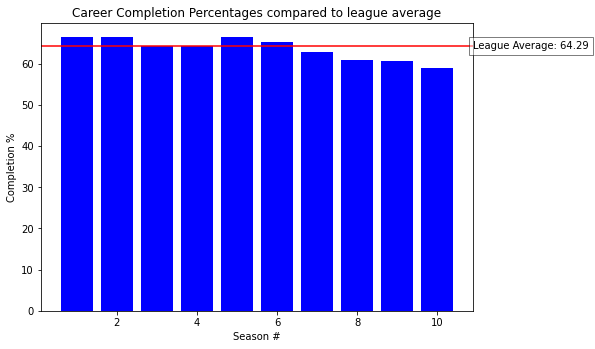

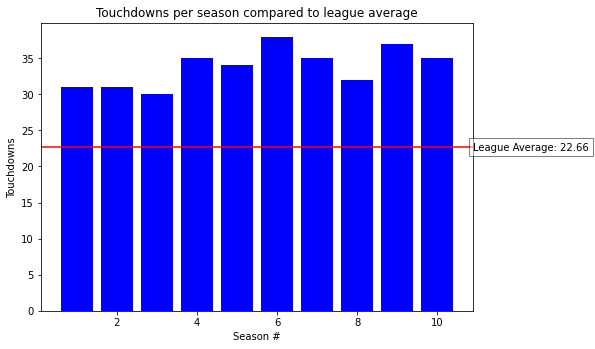

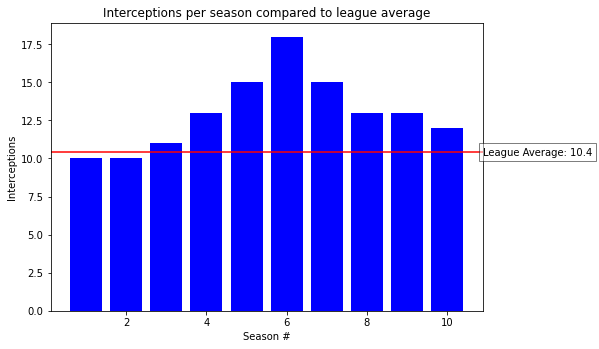

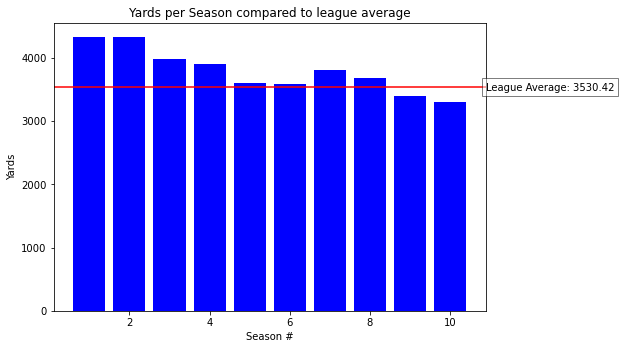

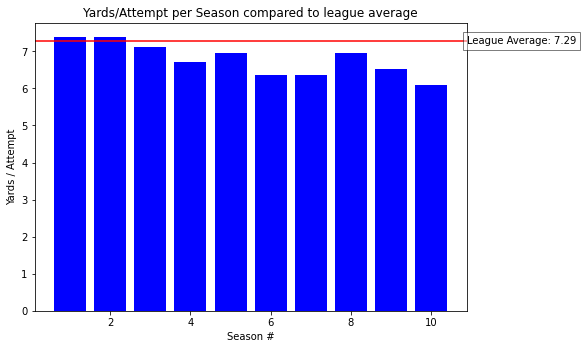

In [12]:
#Graphs all stats per season compared to league average stats
la = list(la)

cps = plt.figure().add_axes([0,0,1,1])
cps.bar(range(1,len(ints)+1),height = comppercents, color = 'b')
cps.axhline(la[0], color="r")
cps.text(1.00, la[0], "League Average: " + str(la[0]), va='center', ha="left", bbox=dict(facecolor="w",alpha=0.5),
        transform=cps.get_yaxis_transform())
cps.set_title('Career Completion Percentages compared to league average')
cps.set_ylabel('Completion %')
cps.set_xlabel('Season #')

tds = plt.figure().add_axes([0,0,1,1])
tds.bar(range(1,len(ints)+1),height = touchdowns, color = 'b')
tds.axhline(la[1], color="r")
tds.text(1.00, la[1], "League Average: " + str(la[1]), va='center', ha="left", bbox=dict(facecolor="w",alpha=0.5),
        transform=tds.get_yaxis_transform())
tds.set_title('Touchdowns per season compared to league average')
tds.set_ylabel('Touchdowns')
tds.set_xlabel('Season #')

ins = plt.figure().add_axes([0,0,1,1])
ins.bar(range(1,len(ints)+1),height = ints, color = 'b')
ins.axhline(la[2], color="r")
ins.text(1.00, la[2], "League Average: " + str(la[2]), va='center', ha="left", bbox=dict(facecolor="w",alpha=0.5),
        transform=ins.get_yaxis_transform())
ins.set_title('Interceptions per season compared to league average')
ins.set_ylabel('Interceptions')
ins.set_xlabel('Season #')

yds = plt.figure().add_axes([0,0,1,1])
yds.bar(range(1,len(ints)+1),height = yards, color = 'b')
yds.axhline(la[3], color="r")
yds.text(1.00, la[3], "League Average: " + str(la[3]), va='center', ha="left", bbox=dict(facecolor="w",alpha=0.5),
        transform=yds.get_yaxis_transform())
yds.set_title('Yards per Season compared to league average')
yds.set_ylabel('Yards')
yds.set_xlabel('Season #')

ydsa = plt.figure().add_axes([0,0,1,1])
ydsa.bar(range(1,len(ints)+1),height = yardsattempts, color = 'b')
ydsa.axhline(la[4], color="r")
ydsa.text(1.00, la[4], "League Average: " + str(la[4]), va='center', ha="left", bbox=dict(facecolor="w",alpha=0.5),
        transform=ydsa.get_yaxis_transform())
ydsa.set_title('Yards/Attempt per Season compared to league average')
ydsa.set_ylabel('Yards / Attempt')
ydsa.set_xlabel('Season #')






